In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set the seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

C:\Users\User\AppData\Local\Temp\ipykernel_292\1697084780.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
class_table = pd.read_csv('DeepGlobe_LandCover_Classification/class_dict.csv')
class_names = class_table['name'].tolist()
label_ids = class_table[['r', 'g', 'b']].values

In [3]:
image_dir = 'DeepGlobe_LandCover_Classification/train_images'
mask_dir = 'DeepGlobe_LandCover_Classification/train_masks'

In [4]:
def load_and_resize_image(filepath, size=(256, 256)):
    image = cv2.imread(filepath)
    image = cv2.resize(image, size)
    return image

def load_and_resize_mask(filepath, size=(256, 256)):
    mask = cv2.imread(filepath)
    mask = cv2.resize(mask, size)
    return mask

def create_label_mask(mask, label_ids):
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    for i, label in enumerate(label_ids):
        is_class = np.all(mask == label, axis=-1)
        label_mask[is_class] = i
    return label_mask


In [5]:
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
mask_files = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')]

images = np.array([load_and_resize_image(f) for f in image_files])
masks = np.array([create_label_mask(load_and_resize_mask(f), label_ids) for f in mask_files])

# Convert masks to categorical
masks = np.expand_dims(masks, axis=-1)
masks = to_categorical(masks, num_classes=len(class_names))

In [6]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [7]:
# Data Augmentation
data_gen_args = dict(horizontal_flip=True, vertical_flip=True, rotation_range=90)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train)
mask_datagen.fit(y_train)

image_generator = image_datagen.flow(X_train, batch_size=16, seed=42)
mask_generator = mask_datagen.flow(y_train, batch_size=16, seed=42)

def combine_generators(image_gen, mask_gen):
    while True:
        image_batch = next(image_gen)
        mask_batch = next(mask_gen)
        yield image_batch, mask_batch

train_generator = combine_generators(image_generator, mask_generator)


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:1494: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (642, 256, 256, 7) (7 channels).
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (642, 256, 256, 7) (7 channels).
  warnings.warn(


In [11]:
# Model Definition
inputs = tf.keras.Input(shape=(256, 256, 3))

# Encoder
conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Dropout(0.1)(conv1)
conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
conv2 = layers.BatchNormalization()(conv2)
conv2 = layers.Dropout(0.1)(conv2)
conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

# Middle
conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
conv3 = layers.BatchNormalization()(conv3)
conv3 = layers.Dropout(0.2)(conv3)
conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

# Decoder
up4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
up4 = layers.concatenate([up4, conv2], axis=3)
conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up4)
conv4 = layers.BatchNormalization()(conv4)
conv4 = layers.Dropout(0.2)(conv4)
conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

up5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
up5 = layers.concatenate([up5, conv1], axis=3)
conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up5)
conv5 = layers.BatchNormalization()(conv5)
conv5 = layers.Dropout(0.1)(conv5)
conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

outputs = layers.Conv2D(len(class_names), 1, activation='softmax')(conv5)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_27 (Conv2D)            │ (None, 256, 256, 64)      │           1,792 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_12        │ (None, 256, 256, 64)      │             256 │ conv2d_27[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 256, 256, 64)      │               0 │ batch_normalization_12[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_28 (Conv2D)            │ (None, 256, 256, 64)      │          36,928 │ dropout_12[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 128, 128, 64)      │               0 │ conv2d_28[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_29 (Conv2D)            │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_13        │ (None, 128, 128, 128)     │             512 │ conv2d_29[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_13 (Dropout)          │ (None, 128, 128, 128)     │               0 │ batch_normalization_13[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_30 (Conv2D)            │ (None, 128, 128, 128)     │         147,584 │ dropout_13[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 64, 64, 128)       │               0 │ conv2d_30[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_31 (Conv2D)            │ (None, 64, 64, 256)       │         295,168 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_14        │ (None, 64, 64, 256)       │           1,024 │ conv2d_31[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_14 (Dropout)          │ (None, 64, 64, 256)       │               0 │ batch_normalization_14[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_32 (Conv2D)            │ (None, 64, 64, 256)       │         590,08

 Total params: 1,865,799 (7.12 MB)

 Trainable params: 1,864,519 (7.11 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [14]:
# Custom callback to save the model every 5 epochs
class CustomSaver(Callback):
    def __init__(self, save_freq=5):
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(f'model_checkpoint_epoch_{epoch + 1:02d}.h5')

In [15]:
# Instantiate the custom callback
custom_saver = CustomSaver(save_freq=5)

# Training with custom callback
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 16,
    epochs=20,  # Example with more epochs
    validation_data=(X_val, y_val),
    callbacks=[custom_saver]
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1117s 28s/step - accuracy: 0.5164 - loss: 1.3978 - val_accuracy: 0.2296 - val_loss: 6.2465
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 988s 25s/step - accuracy: 0.6588 - loss: 0.9947 - val_accuracy: 0.1302 - val_loss: 16.6274
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 998s 25s/step - accuracy: 0.6736 - loss: 0.9029 - val_accuracy: 0.4802 - val_loss: 3.3099
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1000s 25s/step - accuracy: 0.6953 - loss: 0.8652 - val_accuracy: 0.2097 - val_loss: 6.9885
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.6944 - loss: 0.8902 

40/40 ━━━━━━━━━━━━━━━━━━━━ 981s 25s/step - accuracy: 0.6949 - loss: 0.8892 - val_accuracy: 0.3834 - val_loss: 1.7911
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1055s 26s/step - accuracy: 0.6891 - loss: 0.9307 - val_accuracy: 0.4379 - val_loss: 1.3351
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2737s 69s/step - accuracy: 0.7324 - loss: 0.8070 - val_accuracy: 0.2799 - val_loss: 2.3883
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1416s 35s/step - accuracy: 0.7302 - loss: 0.8007 - val_accuracy: 0.5284 - val_loss: 1.3784
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1343s 34s/step - accuracy: 0.7380 - loss: 0.7630 - val_accuracy: 0.7404 - val_loss: 0.8162
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.7406 - loss: 0.7685 

40/40 ━━━━━━━━━━━━━━━━━━━━ 1147s 29s/step - accuracy: 0.7404 - loss: 0.7690 - val_accuracy: 0.7200 - val_loss: 0.7870
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1221s 30s/step - accuracy: 0.7314 - loss: 0.7811 - val_accuracy: 0.5575 - val_loss: 1.1935
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 975s 24s/step - accuracy: 0.7477 - loss: 0.7498 - val_accuracy: 0.7233 - val_loss: 0.7661
Epoch 13/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 966s 24s/step - accuracy: 0.7501 - loss: 0.7613 - val_accuracy: 0.4939 - val_loss: 1.2544
Epoch 14/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 975s 24s/step - accuracy: 0.7512 - loss: 0.7422 - val_accuracy: 0.6922 - val_loss: 1.0699
Epoch 15/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.7584 - loss: 0.7145 

40/40 ━━━━━━━━━━━━━━━━━━━━ 977s 24s/step - accuracy: 0.7582 - loss: 0.7148 - val_accuracy: 0.6887 - val_loss: 0.9034
Epoch 16/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1056s 26s/step - accuracy: 0.7460 - loss: 0.7368 - val_accuracy: 0.7302 - val_loss: 0.7544
Epoch 17/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1417s 35s/step - accuracy: 0.7526 - loss: 0.7103 - val_accuracy: 0.7117 - val_loss: 0.7900
Epoch 18/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1419s 36s/step - accuracy: 0.7583 - loss: 0.6908 - val_accuracy: 0.6787 - val_loss: 0.8696
Epoch 19/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1413s 35s/step - accuracy: 0.7690 - loss: 0.6653 - val_accuracy: 0.6578 - val_loss: 0.9025
Epoch 20/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.7677 - loss: 0.6923 

40/40 ━━━━━━━━━━━━━━━━━━━━ 1266s 32s/step - accuracy: 0.7676 - loss: 0.6929 - val_accuracy: 0.6903 - val_loss: 0.8059


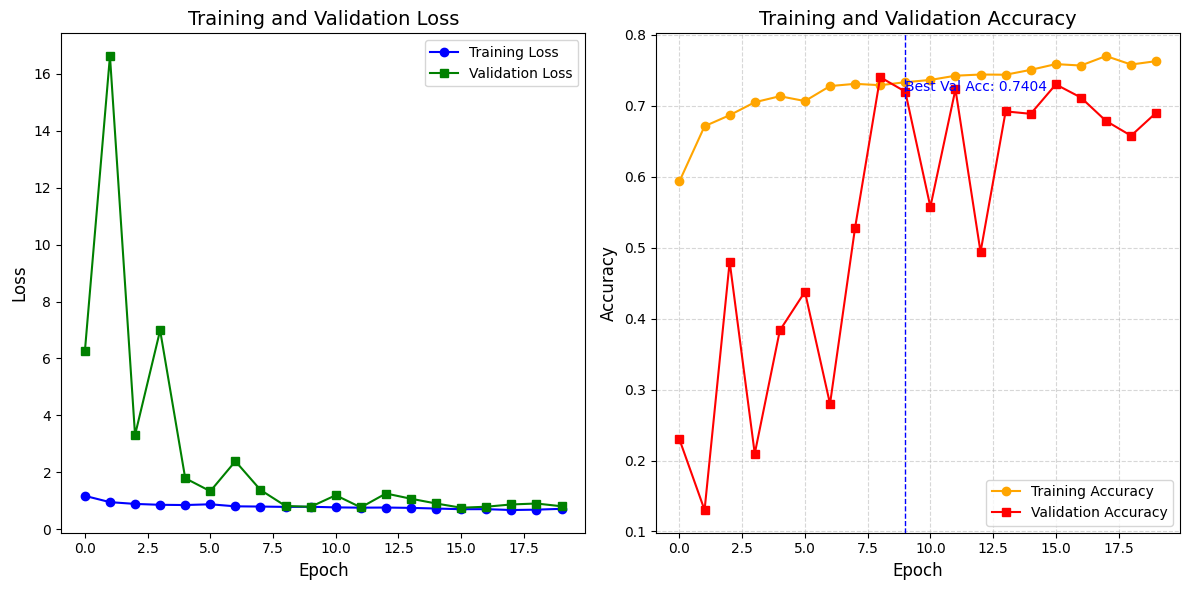

In [51]:
# Plotting Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green', marker='s', linestyle='-')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='orange', marker='o', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', marker='s', linestyle='-')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Highlighting best validation accuracy
best_val_acc_epoch = np.argmax(history.history['val_accuracy']) + 1
plt.subplot(1, 2, 2)
plt.axvline(x=best_val_acc_epoch, color='blue', linestyle='--', linewidth=1)
plt.text(best_val_acc_epoch, max(history.history['val_accuracy']) - 0.02, f'Best Val Acc: {max(history.history["val_accuracy"]):.4f}', color='blue', fontsize=10)

# Adding title and labels with suitable font size
plt.subplot(1, 2, 1)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.subplot(1, 2, 2)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Adding legend with fontsize adjustment
plt.subplot(1, 2, 1)
plt.legend(fontsize=10)

plt.subplot(1, 2, 2)
plt.legend(fontsize=10)

# Adding text annotations for axis labels and ticks with fontsize adjustment
plt.subplot(1, 2, 1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(1, 2, 2)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


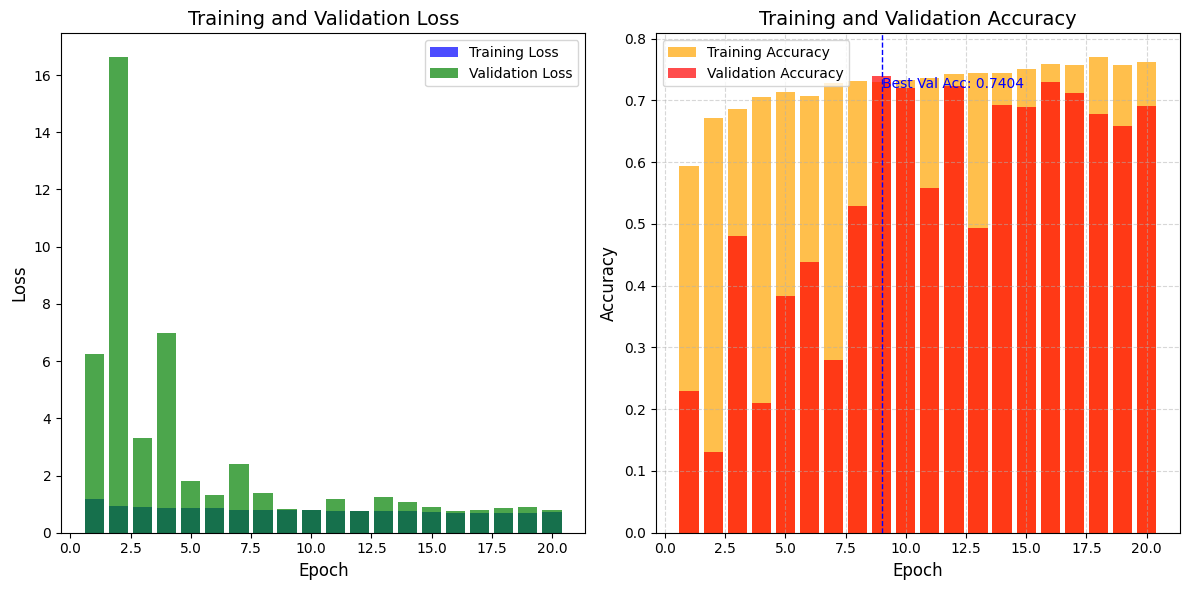

In [55]:
# Plotting Loss and Accuracy as Bar Plots
plt.figure(figsize=(12, 6))

# Loss subplot
plt.subplot(1, 2, 1)
epochs = range(1, len(history.history['loss']) + 1)
plt.bar(epochs, history.history['loss'], color='blue', alpha=0.7, label='Training Loss')
plt.bar(epochs, history.history['val_loss'], color='green', alpha=0.7, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.bar(epochs, history.history['accuracy'], color='orange', alpha=0.7, label='Training Accuracy')
plt.bar(epochs, history.history['val_accuracy'], color='red', alpha=0.7, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Highlighting best validation accuracy
best_val_acc_epoch = np.argmax(history.history['val_accuracy']) + 1
plt.subplot(1, 2, 2)
plt.axvline(x=best_val_acc_epoch, color='blue', linestyle='--', linewidth=1)
plt.text(best_val_acc_epoch, max(history.history['val_accuracy']) - 0.02, f'Best Val Acc: {max(history.history["val_accuracy"]):.4f}', color='blue', fontsize=10)

# Adding title and labels with suitable font size
plt.subplot(1, 2, 1)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.subplot(1, 2, 2)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Adding legend with fontsize adjustment
plt.subplot(1, 2, 1)
plt.legend(fontsize=10)

plt.subplot(1, 2, 2)
plt.legend(fontsize=10)

# Adding text annotations for axis labels and ticks with fontsize adjustment
plt.subplot(1, 2, 1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(1, 2, 2)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


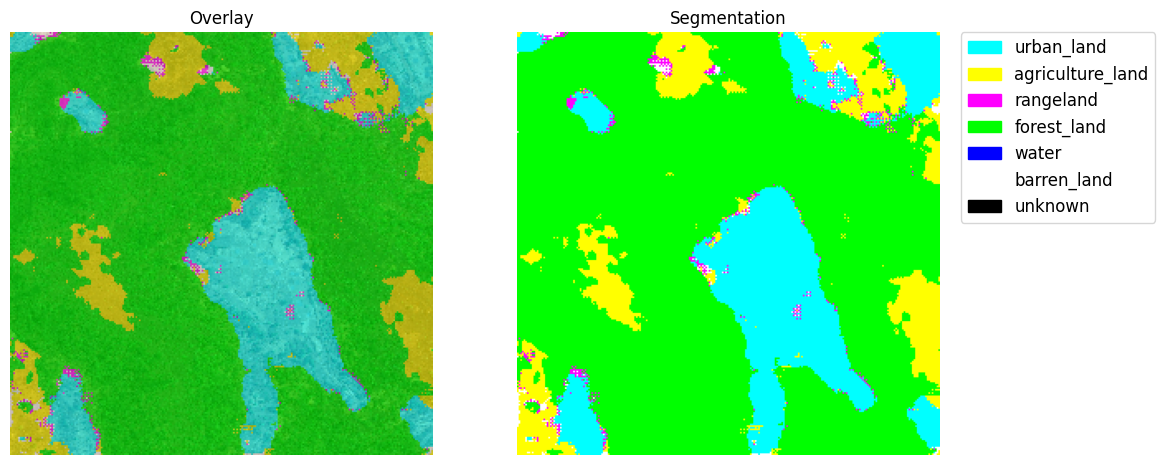

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2

# Test the model on a new image
test_image = cv2.imread('DeepGlobe_LandCover_Classification/test/248389_sat.jpg')
test_image_resized = cv2.resize(test_image, (256, 256))
test_image_expanded = np.expand_dims(test_image_resized, axis=0)

predicted_mask = model.predict(test_image_expanded)[0]
predicted_mask = np.argmax(predicted_mask, axis=-1)

# Color map and visualization
color_class_map = [
    [0, 255, 255],   # urban_land
    [255, 255, 0],   # agriculture_land
    [255, 0, 255],   # rangeland
    [0, 255, 0],     # forest_land
    [0, 0, 255],     # water
    [255, 255, 255], # barren_land
    [0, 0, 0]        # unknown
]

segmentation = np.zeros((256, 256, 3), dtype=np.uint8)
for i, color in enumerate(color_class_map):
    segmentation[predicted_mask == i] = color
    

# Overlay with different weights to improve clarity
overlay = cv2.addWeighted(test_image_resized, 0.4, segmentation, 0.6, 0)

plt.figure(figsize=(12, 6))

# Display original image with overlay
plt.subplot(1, 2, 1)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display segmentation map alone
plt.subplot(1, 2, 2)
plt.title('Segmentation')
plt.imshow(cv2.cvtColor(segmentation, cv2.COLOR_BGR2RGB))
plt.axis('off')
# Create the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


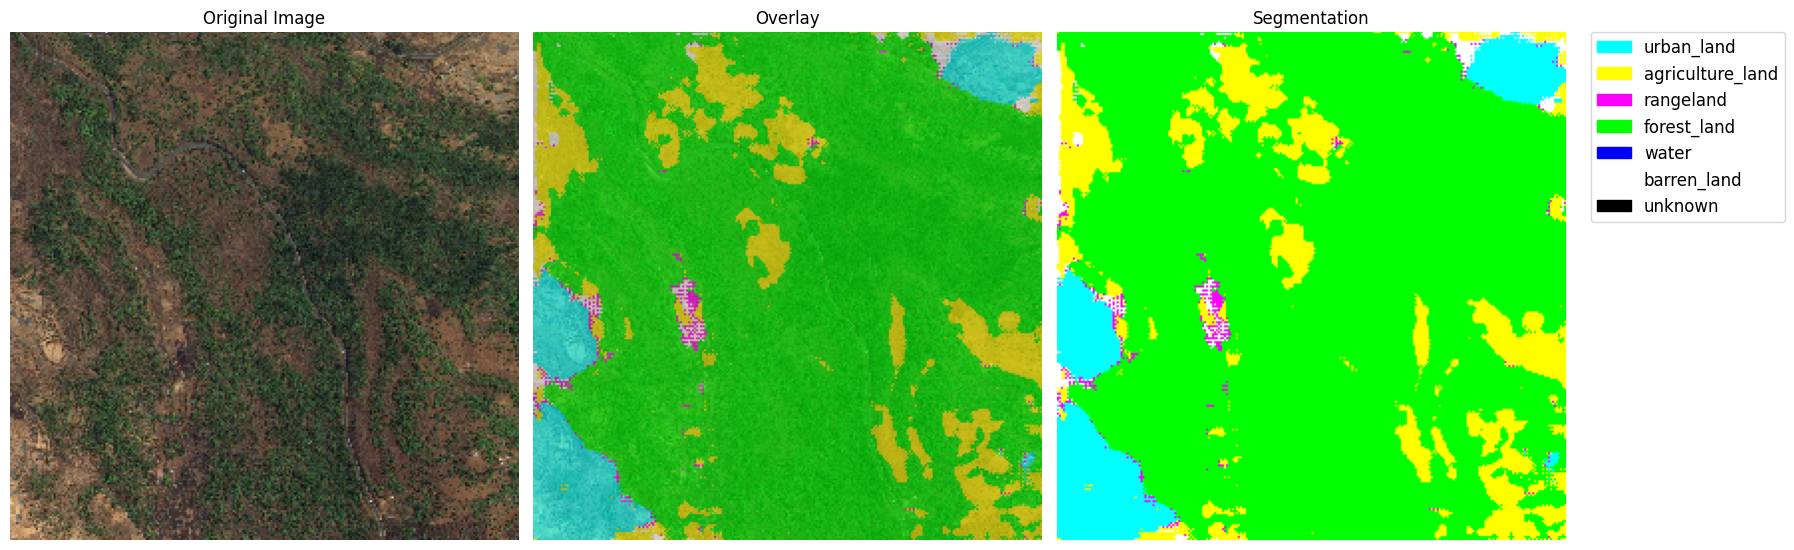

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf

# Load the saved model checkpoint
model = tf.keras.models.load_model('model_checkpoint_epoch_20.h5')  # Replace X with the epoch number you want to visualize

# Load the test image
test_image = cv2.imread('DeepGlobe_LandCover_Classification/test/133160_sat.jpg')
test_image_resized = cv2.resize(test_image, (256, 256))
test_image_expanded = np.expand_dims(test_image_resized, axis=0)

# Use the model to make predictions
predicted_mask = model.predict(test_image_expanded)[0]
predicted_mask = np.argmax(predicted_mask, axis=-1)

# Define color class map
color_class_map = [
    [0, 255, 255],   # urban_land
    [255, 255, 0],   # agriculture_land
    [255, 0, 255],   # rangeland
    [0, 255, 0],     # forest_land
    [0, 0, 255],     # water
    [255, 255, 255], # barren_land
    [0, 0, 0]        # unknown
]

# Create segmentation visualization
segmentation = np.zeros((256, 256, 3), dtype=np.uint8)
for i, color in enumerate(color_class_map):
    segmentation[predicted_mask == i] = color

# Overlay with different weights to improve clarity
overlay = cv2.addWeighted(test_image_resized, 0.4, segmentation, 0.6, 0)

plt.figure(figsize=(18, 6))

# Display original image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(test_image_resized, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display overlay image
plt.subplot(1, 3, 2)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display segmentation map alone
plt.subplot(1, 3, 3)
plt.title('Segmentation')
plt.imshow(cv2.cvtColor(segmentation, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Create legend patches
class_names = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
patches = [mpatches.Patch(color=np.array(color)/255.0, label=class_name) for color, class_name in zip(color_class_map, class_names)]

# Create the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
plt.tight_layout()
plt.show()


In [15]:
# Count pixels for each land type
land_counts = {}
total_pixels = predicted_mask.size

for i, class_name in enumerate(class_names):
    class_pixels = np.count_nonzero(predicted_mask == i)
    land_counts[class_name] = class_pixels / total_pixels * 100

# Print percentage of land types
for class_name, percentage in land_counts.items():
    print(f'{class_name}: {percentage:.2f}%')


urban_land: 12.96%
agriculture_land: 7.75%
rangeland: 0.75%
forest_land: 77.08%
water: 0.00%
barren_land: 1.45%
unknown: 0.00%
